### Import Library

In [ ]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.preprocessing import StandardScaler
from sklearn.cluster import KMeans
from sklearn.mixture import GaussianMixture
from yellowbrick.cluster import KElbowVisualizer
from sklearn.metrics import silhouette_score
from datetime import datetime
import joblib

### Load dataset

In [ ]:
df = pd.read_csv('customer_segmentation.csv')

print(df.shape)
df.head()

(541909, 9)


,index,InvoiceNo,StockCode,Description,Quantity,InvoiceDate,UnitPrice,CustomerID,Country
0,0,536365,85123A,WHITE HANGING HEART T-LIGHT HOLDER,6,12/1/2010 8:26,2.55,17850.0,United Kingdom
1,1,536365,71053,WHITE METAL LANTERN,6,12/1/2010 8:26,3.39,17850.0,United Kingdom
2,2,536365,84406B,CREAM CUPID HEARTS COAT HANGER,8,12/1/2010 8:26,2.75,17850.0,United Kingdom
3,3,536365,84029G,KNITTED UNION FLAG HOT WATER BOTTLE,6,12/1/2010 8:26,3.39,17850.0,United Kingdom
4,4,536365,84029E,RED WOOLLY HOTTIE WHITE HEART.,6,12/1/2010 8:26,3.39,17850.0,United Kingdom


In [ ]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 541909 entries, 0 to 541908
Data columns (total 9 columns):
 #   Column       Non-Null Count   Dtype  
---  ------       --------------   -----  
 0   index        541909 non-null  int64  
 1   InvoiceNo    541909 non-null  object 
 2   StockCode    541909 non-null  object 
 3   Description  540455 non-null  object 
 4   Quantity     541909 non-null  int64  
 5   InvoiceDate  541909 non-null  object 
 6   UnitPrice    541909 non-null  float64
 7   CustomerID   406829 non-null  float64
 8   Country      541909 non-null  object 
dtypes: float64(2), int64(2), object(5)
memory usage: 37.2+ MB


In [ ]:
df.describe()

,index,Quantity,UnitPrice,CustomerID
count,541909.00000,541909.000000,541909.000000,406829.000000
mean,270954.00000,9.552250,4.611114,15287.690570
std,156435.79785,218.081158,96.759853,1713.600303
min,0.00000,-80995.000000,-11062.060000,12346.000000
25%,135477.00000,1.000000,1.250000,13953.000000
50%,270954.00000,3.000000,2.080000,15152.000000
75%,406431.00000,10.000000,4.130000,16791.000000
max,541908.00000,80995.000000,38970.000000,18287.000000


### Preprocessing

In [ ]:
df.isnull().sum()

,0
index,0
InvoiceNo,0
StockCode,0
Description,1454
Quantity,0
InvoiceDate,0
UnitPrice,0
CustomerID,135080
Country,0


In [ ]:
df.duplicated().sum()

np.int64(0)

In [ ]:
# Hapus baris dengan CustomerID atau InvoiceDate kosong
df = df.dropna(subset=['CustomerID', 'InvoiceDate'])

### Konversi Tipe Data & Hitung TotalSales

In [ ]:
# Konversi tanggal dan pastikan kolom numerik valid
df['InvoiceDate'] = pd.to_datetime(df['InvoiceDate'])
for col in ['Quantity', 'UnitPrice']:
  df[col] = pd.to_numeric(df[col], errors='coerce')

In [ ]:
# Hitung nilai transaksi
df['TotalSales'] = df['Quantity'] * df['UnitPrice']
df[["Quantity","UnitPrice","TotalSales"]].head()

,Quantity,UnitPrice,TotalSales
0,6,2.55,15.30
1,6,3.39,20.34
2,8,2.75,22.00
3,6,3.39,20.34
4,6,3.39,20.34


In [ ]:
# Drop kolom index jika ada
if 'index' in df.columns:
    df.drop(columns=['index'], inplace=True)

### Isi Missing Values & Hapus Duplikat

In [ ]:
# Mengisi nilai hilang numerik dengan median & kategorikal dengan modus
num_cols = df.select_dtypes(include=[np.number]).columns
df[num_cols] = df[num_cols].fillna(df[num_cols].median())

for col in df.select_dtypes(include='object').columns:
  df[col] = df[col].fillna(df[col].mode().iloc[0])

df = df.drop_duplicates()
print('Setelah cleaning:', df.shape)

Setelah cleaning: (401604, 9)


In [ ]:
df.isnull().sum()

,0
InvoiceNo,0
StockCode,0
Description,0
Quantity,0
InvoiceDate,0
UnitPrice,0
CustomerID,0
Country,0
TotalSales,0


### EDA: Tren Penjualan Bulanan

In [ ]:
df["InvoiceDate"] = pd.to_datetime(df["InvoiceDate"])
df["Month"] = df["InvoiceDate"].dt.to_period("M")

monthly_sales = df.groupby("Month")["TotalSales"].sum()

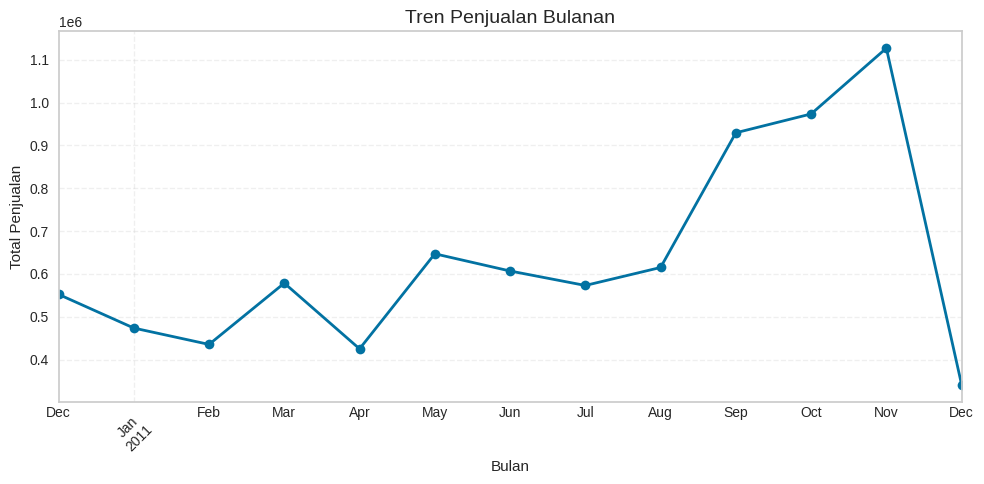

In [ ]:
ax = monthly_sales.plot(figsize=(10,5), linewidth=2, marker='o')
ax.set_title("Tren Penjualan Bulanan", fontsize=14)
ax.set_xlabel("Bulan")
ax.set_ylabel("Total Penjualan")
plt.xticks(rotation=45)
plt.grid(True, linestyle='--', alpha=0.3)
plt.tight_layout()
plt.show()

### Perhitungan RFM

In [ ]:
# Menghitung Recency, Frequency, Monetary
ref_date = df['InvoiceDate'].max() + pd.Timedelta(days=1)

rfm = df.groupby('CustomerID').agg({
'InvoiceDate': lambda x: (ref_date - x.max()).days,
'InvoiceNo': 'nunique',
'TotalSales': 'sum',
}).reset_index()

rfm.columns = ['CustomerID','Recency','Frequency','Monetary']
rfm.head()

,CustomerID,Recency,Frequency,Monetary
0,12346.0,326,2,0.00
1,12347.0,2,7,4310.00
2,12348.0,75,4,1797.24
3,12349.0,19,1,1757.55
4,12350.0,310,1,334.40


### Scaling RFM

In [ ]:
# Menstandarkan RFM agar K-Means bekerja optimal
scaler = StandardScaler()
scaled_rfm = scaler.fit_transform(rfm[["Recency","Frequency","Monetary"]])

scaled_rfm[:5]

array([[ 2.32202285, -0.32936215, -0.23041952],
       [-0.89373323,  0.20610242,  0.29405454],
       [-0.1691956 , -0.11517632, -0.01171748],
       [-0.72500529, -0.43645506, -0.01654727],
       [ 2.16322008, -0.43645506, -0.18972715]])

### Elbow Method & Silhouette Score

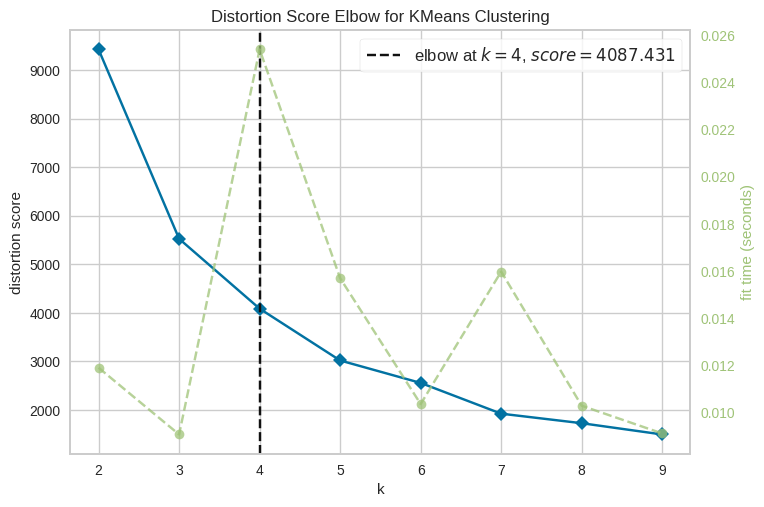

k optimal: 4


{2: np.float64(0.5568571220409062),
 3: np.float64(0.5882428352236619),
 4: np.float64(0.6143653068975217),
 5: np.float64(0.5898984800372042),
 6: np.float64(0.5115159970222058),
 7: np.float64(0.5214157119931198),
 8: np.float64(0.5214818642014245),
 9: np.float64(0.5171343610193163),
 10: np.float64(0.47823112330203627)}

In [ ]:
# Menentukan jumlah cluster terbaik
model = KMeans(random_state=42)
visualizer = KElbowVisualizer(model, k=(2,10))
visualizer.fit(scaled_rfm)
visualizer.show()

k_optimal = visualizer.elbow_value_
print("k optimal:", k_optimal)

sil_scores = {}
for k in range(2,11):
    km = KMeans(n_clusters=k, random_state=42)
    labels = km.fit_predict(scaled_rfm)
    sil_scores[k] = silhouette_score(scaled_rfm, labels)

sil_scores

### Train KMeans Final

In [ ]:
# Melatih model KMeans dengan k yang dipilih
k = int(k_optimal) if k_optimal else 4
kmeans = KMeans(n_clusters=k, random_state=42)

rfm["Cluster"] = kmeans.fit_predict(scaled_rfm)

joblib.dump(kmeans, "kmeans_rfm_model.joblib")
joblib.dump(scaler, "scaler_rfm.joblib")

rfm.head()

,CustomerID,Recency,Frequency,Monetary,Cluster
0,12346.0,326,2,0.00,1
1,12347.0,2,7,4310.00,3
2,12348.0,75,4,1797.24,3
3,12349.0,19,1,1757.55,3
4,12350.0,310,1,334.40,1


### Visualisasi RFM

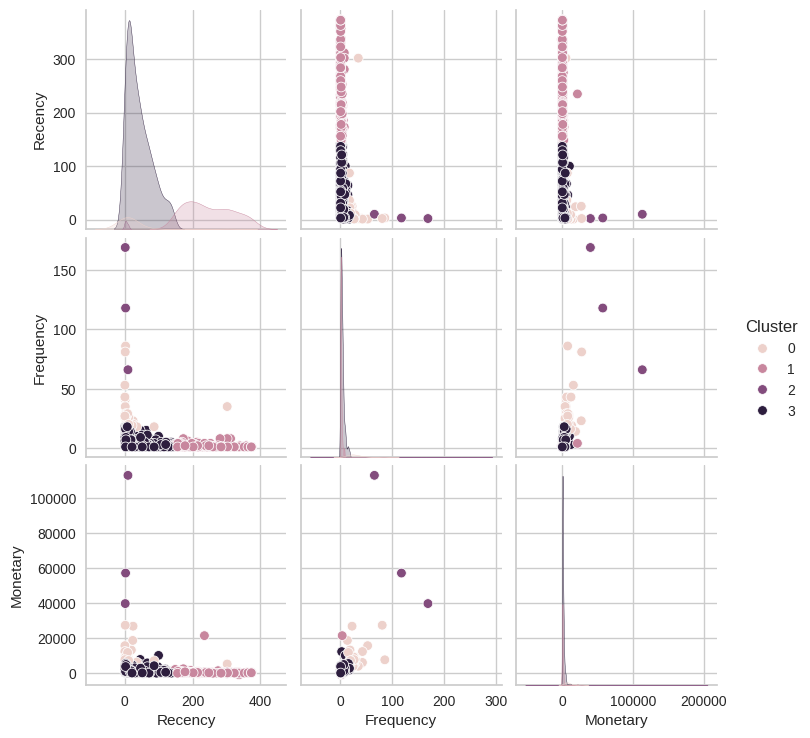

In [ ]:
# pairplot untuk melihat pola cluster
sample = rfm.sample(n=min(600, len(rfm)), random_state=42)
sns.pairplot(sample[['Recency','Frequency','Monetary','Cluster']], hue='Cluster')
plt.show()

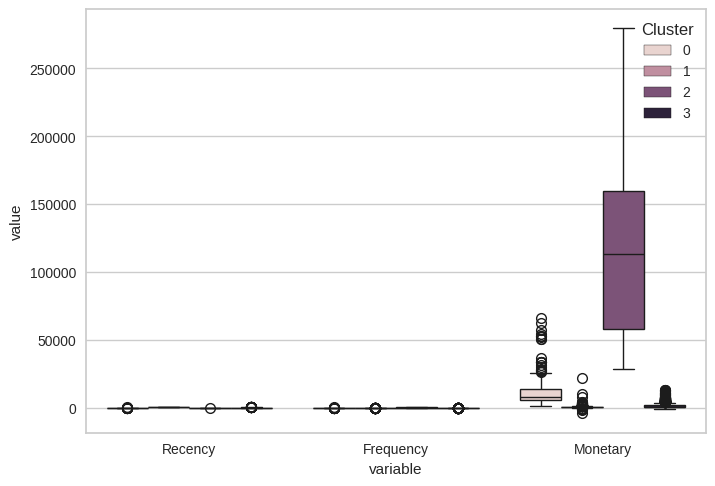

In [ ]:
# Boxplot
rfm_melted = pd.melt(rfm, id_vars=['Cluster'], value_vars=['Recency','Frequency','Monetary'])
sns.boxplot(data=rfm_melted, x='variable', y='value', hue='Cluster')
plt.show()

### Summary Cluster

In [ ]:
# Ringkasan cluster untuk analisis
cluster_summary = rfm.groupby("Cluster").agg({
    "Recency":"mean",
    "Frequency":"mean",
    "Monetary":"mean",
    "CustomerID":"count"
}).rename(columns={"CustomerID":"Count"})

cluster_summary

,Recency,Frequency,Monetary,Count
Cluster,,,,
0,10.787565,28.575130,12190.961710,193
1,248.927577,1.805942,453.425572,1077
2,5.090909,109.909091,124150.432727,11
3,42.768360,4.374313,1317.266164,3091


### Interpretasi & Insight Pemasaran

In [ ]:
cluster_labels = {
    0: "Loyalists - sering membeli & nilai tinggi",
    1: "At Risk - jarang transaksi baru-baru ini",
    2: "Big Spenders - nilai transaksi besar",
    3: "New Customers - pelanggan baru"
}

rfm['Segment'] = rfm['Cluster'].map(cluster_labels)
rfm

,CustomerID,Recency,Frequency,Monetary,Cluster,Segment
0,12346.0,326,2,0.00,1,At Risk - jarang transaksi baru-baru ini
1,12347.0,2,7,4310.00,3,New Customers - pelanggan baru
2,12348.0,75,4,1797.24,3,New Customers - pelanggan baru
3,12349.0,19,1,1757.55,3,New Customers - pelanggan baru
4,12350.0,310,1,334.40,1,At Risk - jarang transaksi baru-baru ini
...,...,...,...,...,...,...
4367,18280.0,278,1,180.60,1,At Risk - jarang transaksi baru-baru ini
4368,18281.0,181,1,80.82,1,At Risk - jarang transaksi baru-baru ini
4369,18282.0,8,3,176.60,3,New Customers - pelanggan baru
4370,18283.0,4,16,2045.53,3,New Customers - pelanggan baru


In [ ]:
print("=== INTERPRETASI SEGMENTASI ===")
for c, label in cluster_labels.items():
    print(f"\nCluster {c} → {label}")

    if "Loyalists" in label:
        print("- Program loyalitas & reward eksklusif.")
    elif "At Risk" in label:
        print("- Promo re-engagement, reminder email, comeback voucher.")
    elif "Big Spenders" in label:
        print("- Produk premium, personalisasi layanan, VIP support.")
    elif "New Customers" in label:
        print("- Welcome promo, edukasi produk, follow up pembelian.")

=== INTERPRETASI SEGMENTASI ===

Cluster 0 → Loyalists - sering membeli & nilai tinggi
- Program loyalitas & reward eksklusif.

Cluster 1 → At Risk - jarang transaksi baru-baru ini
- Promo re-engagement, reminder email, comeback voucher.

Cluster 2 → Big Spenders - nilai transaksi besar
- Produk premium, personalisasi layanan, VIP support.

Cluster 3 → New Customers - pelanggan baru
- Welcome promo, edukasi produk, follow up pembelian.
